<a href="https://colab.research.google.com/github/athiq-ahmed/Pytorch/blob/master/Captcha_recognition_using_PyTorch_(Convolutional_RNN_%2B_CTC_Loss).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Sep 12 10:56:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    227      0 --:--:-- --:--:-- --:--:--   226
100 8863k  100 8863k    0     0  6070k      0  0:00:01  0:00:01 --:--:-- 39.8M


In [3]:
!unzip -qq captcha_images_v2.zip

### Config.py

In [22]:
DATA_DIR = '/content/captcha_images_v2'
BATCH_SIZE = 8
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 75
NUM_WORKERS = 4
EPOCHS = 200
DEVICE = "cuda"

In [5]:
import glob
# glob.glob('/content/captcha_images_v2/*.png')

### Dataset.py

In [6]:
import albumentations # for augmentations
import torch
import numpy as np

from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
class ClassificationDataset:
  def __init__(self, image_paths, targets, resize=None):
    self.image_paths = image_paths
    self.targets = targets
    self.resize = resize
    self.aug = albumentations.Compose([albumentations.Normalize(always_apply=True)])

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, item):
    image = Image.open(self.image_paths[item]).convert("RGB")
    targets = self.targets[item]

    if self.resize is not None:
      image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)

    image = np.array(image)
    augmented = self.aug(image=image)
    image = augmented["image"]
    image = np.transpose(image, (2,0,1)).astype(np.float32)

    return {
        "images": torch.tensor(image, dtype=torch.float),
        "targets": torch.tensor(targets, dtype=torch.long)
    }

### engine.py

In [8]:
from tqdm import tqdm
import torch

def train_fn(model, data_loader, optimizer):
  model.train()
  fin_loss = 0
  tk = tqdm(data_loader, total=len(data_loader))
  for data in tk:
    for k, v in data.items():
      data[k] = v.to(DEVICE)
    optimizer.zero_grad()
    _, loss = model(**data)
    loss.backward()
    optimizer.step()
    fin_loss += loss
  return fin_loss / len(data_loader)

def eval_fn(model, data_loader):
  model.eval()
  fin_loss = 0
  fin_preds = []
  with torch.no_grad():
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
      for k, v in data.items():
        data[k] = v.to(DEVICE)

      preds, loss = model(**data)
      fin_loss += loss
      fin_preds.append(preds)
    return fin_preds, fin_loss / len(data_loader)

### model.py

In [13]:
import torch
from torch import nn
from torch.nn import functional as F

class CaptchaModel(nn.Module):
  def __init__(self, num_chars):
    super(CaptchaModel, self).__init__()
    self.conv_1 = nn.Conv2d(3, 128, kernel_size=(3,3), padding=(1,1))
    self.max_pool_1 = nn.MaxPool2d(kernel_size=(2,2))
    self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
    self.max_pool_2 = nn.MaxPool2d(kernel_size=(2,2))

    self.linear_1 = nn.Linear(1152, 64)
    self.drop_1= nn.Dropout(0.2)

    self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25)
    self.output = nn.Linear(64, num_chars+1)

  def forward(self, images, targets=None):
    bs, c, h, w = images.size()
    # print(bs, c, h, w)
    x = F.relu(self.conv_1(images))
    # print(x.size())
    x = self.max_pool_1(x)
    # print(x.size())
    x = F.relu(self.conv_2(x))
    # print(x.size())
    x = self.max_pool_2(x) # [1, 64, 18, 75]
    # print(x.size())
    x = x.permute(0,3,1,2) # [1, 75, 64, 18]
    # print(x.size())
    x = x.view(bs, x.size(1), -1)
    # print(x.size()) #[1, 75, 1152]
    x = self.linear_1(x)
    x = self.drop_1(x)
    # print(x.size())
    x, _ = self.gru(x)
    # print(x.size())
    x = self.output(x)
    # print(x.size())
    x = x.permute(1,0,2)
    # print(x.size())

    if targets is not None:
      log_softmax_values = F.log_softmax(x, 2)
      input_lengths = torch.full(size=(bs,),fill_value=log_softmax_values.size(0),dtype=torch.int32)
      # print(input_lengths)
      target_lengths = torch.full(size=(bs,),fill_value=targets.size(1),dtype=torch.int32)
      # print(target_lengths)
      loss = nn.CTCLoss(blank=0)(log_softmax_values, targets, input_lengths, target_lengths)
      return x, loss

    return x, None

if __name__ == "__main__":
  cm = CaptchaModel(19)
  img = torch.rand(1,3,75,300)
  target = torch.randint(1,20,(1,5))
  x, loss = cm(img, target)


### train.py

In [23]:
import os
import glob
import torch
import numpy as np

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

from pprint import pprint

def decode_predictions(preds, encoder):
  preds = preds.permute(1, 0 ,2)
  preds = torch.softmax(preds, 2)
  preds = torch.argmax(preds, 2)
  preds = preds.detach().cpu().numpy()
  cap_preds = []
  for j in range(preds.shape[0]):
    temp = []
    for k in preds[j, :]:
      k = k-1
      if k == -1:
        temp.append("`")
      else:
        temp.append(encoder.inverse_transform([k])[0])
    tp = "".join(temp)
    cap_preds.append(tp)
    return cap_preds


def run_traning():
  image_files = glob.glob('/content/captcha_images_v2/*.png')
  targets_orig = [x.split('/')[-1][:4] for x in image_files]  # "'../../../abcd.png"
  targets = [[c for c in x] for x in targets_orig]  # abcd --> [a, b, c, d]
  targets_flat = [c for clist in targets for c in clist]

  lbl_enc = preprocessing.LabelEncoder()
  lbl_enc.fit(targets_flat)
  targets_enc = [lbl_enc.transform(x) for x in targets]
  targets_enc = np.array(targets_enc) + 1


  (train_imgs, test_imgs, train_targets, test_targets, train_orig_targets, test_orig_targets) = \
  model_selection.train_test_split(image_files, targets_enc, targets_orig, test_size=0.1, random_state=42)

  train_dataset = ClassificationDataset(image_paths=train_imgs, targets=train_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))
  test_dataset = ClassificationDataset(image_paths=test_imgs, targets=test_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

  model = CaptchaModel(num_chars=len(lbl_enc.classes_))
  model.to(DEVICE)

  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=5, verbose=True)

  for epoch in range(EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_fn(model, test_loader)

    valid_cap_preds=[]
    for vp in valid_preds:
      current_preds = decode_predictions(vp, lbl_enc)
      valid_cap_preds.extend(current_preds)
    pprint(list(zip(test_orig_targets, valid_cap_preds))[6:10])
    print(f'EPOCH:{epoch}, train_loss={train_loss}, valid_loss={valid_loss}')

  # print(targets)
  # print('*'*100)
  # print(np.unique(targets_flat))
  # print('*'*100)
  # print(targets_enc)
  # print('*'*100)
  # print(len(lbl_enc.classes_))


run_traning()

  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:0, train_loss=9.905404090881348, valid_loss=3.4535133838653564


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:1, train_loss=3.4397318363189697, valid_loss=3.404492139816284


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:2, train_loss=3.3890697956085205, valid_loss=3.388254404067993


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:3, train_loss=3.3717336654663086, valid_loss=3.3790199756622314


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:4, train_loss=3.362989902496338, valid_loss=3.3702802658081055


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:5, train_loss=3.3561618328094482, valid_loss=3.3662092685699463


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:6, train_loss=3.3505239486694336, valid_loss=3.364133596420288


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:7, train_loss=3.3464579582214355, valid_loss=3.361543655395508


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:8, train_loss=3.34285306930542, valid_loss=3.3619632720947266


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:9, train_loss=3.3390393257141113, valid_loss=3.355255365371704


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:10, train_loss=3.3388476371765137, valid_loss=3.3513834476470947


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:11, train_loss=3.3356552124023438, valid_loss=3.3473594188690186


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:12, train_loss=3.335153341293335, valid_loss=3.349532127380371


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:13, train_loss=3.333218812942505, valid_loss=3.349372625350952


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:14, train_loss=3.3329601287841797, valid_loss=3.3464395999908447


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:15, train_loss=3.332822322845459, valid_loss=3.347621202468872


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:16, train_loss=3.334022045135498, valid_loss=3.342625617980957


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:17, train_loss=3.3322081565856934, valid_loss=3.3501100540161133


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:18, train_loss=3.3323793411254883, valid_loss=3.346386432647705


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:19, train_loss=3.331843614578247, valid_loss=3.3501055240631104


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:20, train_loss=3.3312225341796875, valid_loss=3.3466498851776123


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:21, train_loss=3.3321213722229004, valid_loss=3.347550392150879


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:22, train_loss=3.332225799560547, valid_loss=3.350619316101074


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:23, train_loss=3.3328347206115723, valid_loss=3.3512513637542725


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:24, train_loss=3.332076072692871, valid_loss=3.343177080154419


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:25, train_loss=3.3322081565856934, valid_loss=3.348159074783325


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:26, train_loss=3.333000898361206, valid_loss=3.348562479019165


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:27, train_loss=3.3322887420654297, valid_loss=3.3446571826934814


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:28, train_loss=3.33298659324646, valid_loss=3.3450284004211426


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:29, train_loss=3.3329033851623535, valid_loss=3.341266393661499


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:30, train_loss=3.332136869430542, valid_loss=3.3472769260406494


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:31, train_loss=3.332273483276367, valid_loss=3.341991662979126


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:32, train_loss=3.332775115966797, valid_loss=3.347782611846924


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:33, train_loss=3.332876205444336, valid_loss=3.3487424850463867


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:34, train_loss=3.3331713676452637, valid_loss=3.342200756072998


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:35, train_loss=3.33241605758667, valid_loss=3.3453633785247803


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:36, train_loss=3.3335416316986084, valid_loss=3.345694065093994


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:37, train_loss=3.332421064376831, valid_loss=3.349614143371582


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:38, train_loss=3.3329219818115234, valid_loss=3.3413262367248535


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:39, train_loss=3.3320746421813965, valid_loss=3.351425886154175


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:40, train_loss=3.3326401710510254, valid_loss=3.3432788848876953


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:41, train_loss=3.332609176635742, valid_loss=3.347522258758545


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:42, train_loss=3.330312967300415, valid_loss=3.349771738052368


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:43, train_loss=3.3267712593078613, valid_loss=3.362938642501831


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:44, train_loss=3.311652660369873, valid_loss=3.2741711139678955


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````````````````````````````````````````````````````````````'),
 ('cdmn',
  '```````````````````````````````````````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````p````````````````````````````````````````````````')]
EPOCH:45, train_loss=3.2315046787261963, valid_loss=3.1498029232025146


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '`````````````````````````````d`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````d``````````````````````````d``````````````````````````````'),
 ('5mff',
  '``````````````````````````p````````````````````````````````````````````````')]
EPOCH:46, train_loss=3.074951410293579, valid_loss=2.99765944480896


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '`````````````````````````````d`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````d``````````````````````````b``````````````````````````````'),
 ('5mff',
  '``````````````````````````p````````````````````````````````````````````````')]
EPOCH:47, train_loss=2.892859697341919, valid_loss=2.8141705989837646


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '`````````````````````````````d`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````d``````````````````````````d``````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:48, train_loss=2.7163848876953125, valid_loss=2.5996382236480713


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '`````````````````````````````d`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````4``````````````````````````4``````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:49, train_loss=2.5230789184570312, valid_loss=2.4098148345947266


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '```````````````````n````n````d`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n``````````4``````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:50, train_loss=2.375422239303589, valid_loss=2.332526922225952


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````````````````````````````````````'),
 ('pe4x',
  '`````````````````````````````d`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````4``````````````````````````4``````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:51, train_loss=2.2090742588043213, valid_loss=2.17313814163208


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````3```````````````````````````````'),
 ('pe4x',
  '```````````````````n````n````f`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n``````````4``````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:52, train_loss=2.0142593383789062, valid_loss=1.9257420301437378


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n``````````4``````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:53, train_loss=1.814183235168457, valid_loss=1.678654670715332


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````````````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n`````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:54, train_loss=1.6118392944335938, valid_loss=1.470862627029419


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '```````````````````````````````````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n`````````````````````````````````````````'),
 ('5mff',
  '```````````````````````````````````````````````````````````````````````````')]
EPOCH:55, train_loss=1.4654115438461304, valid_loss=1.282059907913208


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:56, train_loss=1.2793381214141846, valid_loss=1.1209325790405273


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '``````````````````````````g`````````````````````y``````````````````````````')]
EPOCH:57, train_loss=1.141470193862915, valid_loss=0.9876043200492859


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n`````````````````````````````````````````'),
 ('5mff',
  '``````````````````````````g````````````````````````````````````````````````')]
EPOCH:58, train_loss=1.0586903095245361, valid_loss=0.9217778444290161


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:59, train_loss=0.9521371126174927, valid_loss=0.8886396884918213


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:60, train_loss=0.9059163928031921, valid_loss=0.7847957015037537


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````e`````````````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:61, train_loss=0.8444591164588928, valid_loss=0.801410973072052


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````e`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:62, train_loss=0.7927006483078003, valid_loss=0.6803922057151794


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:63, train_loss=0.7400910258293152, valid_loss=0.6692584156990051


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````e`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:64, train_loss=0.6892109513282776, valid_loss=0.6199978590011597


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:65, train_loss=0.6634732484817505, valid_loss=0.5681484341621399


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:66, train_loss=0.5897229909896851, valid_loss=0.5154878497123718


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xc````````````````````````````````')]
EPOCH:67, train_loss=0.5982179045677185, valid_loss=0.5605972409248352


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2````````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:68, train_loss=0.5308178663253784, valid_loss=0.5281373262405396


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xc````````````````````````````````')]
EPOCH:69, train_loss=0.5129795074462891, valid_loss=0.4726567566394806


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ee``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xc````````````````````````````````')]
EPOCH:70, train_loss=0.4831222891807556, valid_loss=0.46699199080467224


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:71, train_loss=0.4607820510864258, valid_loss=0.4741230309009552


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:72, train_loss=0.45768076181411743, valid_loss=0.5109544992446899


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n````n````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:73, train_loss=0.4271431267261505, valid_loss=0.4376298189163208


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x``````y``````````````````````````')]
EPOCH:74, train_loss=0.39613327383995056, valid_loss=0.4233682155609131


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:75, train_loss=0.38622575998306274, valid_loss=0.4370478391647339


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:76, train_loss=0.37456583976745605, valid_loss=0.4256039261817932


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:77, train_loss=0.34375664591789246, valid_loss=0.34734830260276794


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:78, train_loss=0.339869886636734, valid_loss=0.3976546823978424


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:79, train_loss=0.3101404011249542, valid_loss=0.4164794683456421


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x`````````````````````````````````')]
EPOCH:80, train_loss=0.32411372661590576, valid_loss=0.37924930453300476


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xx````````````````````````````````')]
EPOCH:81, train_loss=0.29915982484817505, valid_loss=0.404900461435318


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xc`````y``````````````````````````')]
EPOCH:82, train_loss=0.2844698131084442, valid_loss=0.4750444293022156


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x``````y``````````````````````````')]
EPOCH:83, train_loss=0.2865741550922394, valid_loss=0.369041383266449


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g```````````````c````````````````````````````````')]
EPOCH:84, train_loss=0.26868152618408203, valid_loss=0.37261971831321716


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:85, train_loss=0.251901775598526, valid_loss=0.44398242235183716


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x``````y``````````````````````````')]
EPOCH:86, train_loss=0.26031988859176636, valid_loss=0.3924354910850525


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xc`````y``````````````````````````')]
EPOCH:87, train_loss=0.25662747025489807, valid_loss=0.36044251918792725


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:88, train_loss=0.22505322098731995, valid_loss=0.41766393184661865


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:89, train_loss=0.230620875954628, valid_loss=0.4446087181568146


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xc`````y``````````````````````````')]
EPOCH:90, train_loss=0.21152621507644653, valid_loss=0.39522016048431396


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:91, train_loss=0.23305644094944, valid_loss=0.4523769021034241


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:92, train_loss=0.20984700322151184, valid_loss=0.38361433148384094


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x`````````````````````````````````')]
EPOCH:93, train_loss=0.20643150806427002, valid_loss=0.4146820306777954


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xx````````````````````````````````')]
EPOCH:94, train_loss=0.2117009162902832, valid_loss=0.3890894055366516


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:95, train_loss=0.18095190823078156, valid_loss=0.3703099191188812


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:96, train_loss=0.19526274502277374, valid_loss=0.35921603441238403


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:97, train_loss=0.17638514935970306, valid_loss=0.4170639216899872


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xx`````y``````````````````````````')]
EPOCH:98, train_loss=0.20080289244651794, valid_loss=0.40508323907852173


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xx`````y``````````````````````````')]
EPOCH:99, train_loss=0.1878998875617981, valid_loss=0.40774405002593994


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:100, train_loss=0.19189725816249847, valid_loss=0.3976854085922241


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:101, train_loss=0.15684917569160461, valid_loss=0.34319984912872314


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x``````y``````````````````````````')]
EPOCH:102, train_loss=0.1582990288734436, valid_loss=0.36702197790145874


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x``````y``````````````````````````')]
EPOCH:103, train_loss=0.17140157520771027, valid_loss=0.4009631872177124


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:104, train_loss=0.1491871178150177, valid_loss=0.4393017888069153


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x`````````````````````````````````')]
EPOCH:105, train_loss=0.16061115264892578, valid_loss=0.41570454835891724


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x`````````````````````````````````')]
EPOCH:106, train_loss=0.1905299425125122, valid_loss=0.38358041644096375


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:107, train_loss=0.16470317542552948, valid_loss=0.376022070646286


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x`````````````````````````````````')]
EPOCH:108, train_loss=0.18197032809257507, valid_loss=0.4122648537158966


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:109, train_loss=0.14995422959327698, valid_loss=0.3628367483615875


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x`````````````````````````````````')]
EPOCH:110, train_loss=0.15739895403385162, valid_loss=0.40682655572891235


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xx`````y``````````````````````````')]
EPOCH:111, train_loss=0.13315804302692413, valid_loss=0.5249150991439819


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4````c``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x`````````````````````````````````')]
EPOCH:112, train_loss=0.1662246137857437, valid_loss=0.4674224257469177


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x``````y``````````````````````````')]
EPOCH:113, train_loss=0.12598241865634918, valid_loss=0.3963611423969269


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xc`````y``````````````````````````')]
EPOCH:114, train_loss=0.13158388435840607, valid_loss=0.3907075822353363


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x``````y``````````````````````````')]
EPOCH:115, train_loss=0.13652347028255463, valid_loss=0.4149690866470337


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:116, train_loss=0.12507407367229462, valid_loss=0.40223294496536255


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x``````y``````````````````````````')]
EPOCH:117, train_loss=0.11737779527902603, valid_loss=0.44228288531303406


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x``````y``````````````````````````')]
EPOCH:118, train_loss=0.15990707278251648, valid_loss=0.43913576006889343


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:119, train_loss=0.13345251977443695, valid_loss=0.474073201417923


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:120, train_loss=0.12708890438079834, valid_loss=0.6631064414978027


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:121, train_loss=0.13397637009620667, valid_loss=0.38064175844192505


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:122, train_loss=0.11550870537757874, valid_loss=0.46260592341423035


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:123, train_loss=0.14535288512706757, valid_loss=0.4769616425037384


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``m`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x``````y``````````````````````````')]
EPOCH:124, train_loss=0.11205869168043137, valid_loss=0.4546809494495392


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x``````y``````````````````````````')]
EPOCH:125, train_loss=0.12808051705360413, valid_loss=0.48331448435783386


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '``````````````````````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````````````````````````````````````````````````')]
EPOCH:126, train_loss=0.10843499004840851, valid_loss=0.5454211831092834


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x``````y``````````````````````````')]
EPOCH:127, train_loss=0.11570651829242706, valid_loss=0.46135687828063965


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xx`````y``````````````````````````')]
EPOCH:128, train_loss=0.09473355859518051, valid_loss=0.4330219030380249


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:129, train_loss=0.09519524872303009, valid_loss=0.5977135896682739


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:130, train_loss=0.11001092195510864, valid_loss=0.4141083061695099


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:131, train_loss=0.14225125312805176, valid_loss=0.4315624535083771


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:132, train_loss=0.13099586963653564, valid_loss=0.6429417133331299


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:133, train_loss=0.11809608340263367, valid_loss=0.5072861909866333


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:134, train_loss=0.09085524082183838, valid_loss=0.5982946753501892


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:135, train_loss=0.12032587826251984, valid_loss=0.44209033250808716


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xx````````````````````````````````')]
EPOCH:136, train_loss=0.13412977755069733, valid_loss=0.4472528398036957


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:137, train_loss=0.09007575362920761, valid_loss=0.4603426456451416


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``m`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:138, train_loss=0.08807957172393799, valid_loss=0.47403836250305176


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xx`````y``````````````````````````')]
EPOCH:139, train_loss=0.09466566890478134, valid_loss=0.4960511028766632


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c````````````````y``````````````````````````')]
EPOCH:140, train_loss=0.11613816767930984, valid_loss=0.5172325372695923


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:141, train_loss=0.08581878244876862, valid_loss=0.5293116569519043


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:142, train_loss=0.1028340682387352, valid_loss=0.5258876085281372


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````w`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x``````y``````````````````````````')]
EPOCH:143, train_loss=0.09425168484449387, valid_loss=0.4848794639110565


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x``````y``````````````````````````')]
EPOCH:144, train_loss=0.07985923439264297, valid_loss=0.5739704370498657


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4````c``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:145, train_loss=0.092489093542099, valid_loss=0.5299760699272156


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:146, train_loss=0.09165062010288239, valid_loss=0.5026422739028931


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:147, train_loss=0.07169639319181442, valid_loss=0.4597616493701935


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:148, train_loss=0.07650800049304962, valid_loss=0.5150713324546814


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:149, train_loss=0.11225167661905289, valid_loss=0.47439080476760864


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x``````y``````````````````````````')]
EPOCH:150, train_loss=0.09320614486932755, valid_loss=0.48873794078826904


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x``````y``````````````````````````')]
EPOCH:151, train_loss=0.09067755937576294, valid_loss=0.49542510509490967


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4````c``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:152, train_loss=0.08384016156196594, valid_loss=0.5557274222373962


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:153, train_loss=0.08879657834768295, valid_loss=0.46658656001091003


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x``````y``````````````````````````')]
EPOCH:154, train_loss=0.09670890867710114, valid_loss=0.49166589975357056


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:155, train_loss=0.07836147397756577, valid_loss=0.5490219593048096


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:156, train_loss=0.06993050873279572, valid_loss=0.47272107005119324


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:157, train_loss=0.06679008901119232, valid_loss=0.4718140661716461


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:158, train_loss=0.06630504876375198, valid_loss=0.4641155004501343


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:159, train_loss=0.06132695823907852, valid_loss=0.51543790102005


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:160, train_loss=0.0831330418586731, valid_loss=0.4892900586128235


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:161, train_loss=0.07733233273029327, valid_loss=0.46686986088752747


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:162, train_loss=0.07091403752565384, valid_loss=0.4951123297214508


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xc`````y``````````````````````````')]
EPOCH:163, train_loss=0.08893627673387527, valid_loss=0.5729823708534241


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x`````````````````````````````````')]
EPOCH:164, train_loss=0.09853294491767883, valid_loss=0.64848792552948


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:165, train_loss=0.06705030053853989, valid_loss=0.4893243610858917


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:166, train_loss=0.06274557113647461, valid_loss=0.47753551602363586


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:167, train_loss=0.08587037771940231, valid_loss=0.4522061049938202


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:168, train_loss=0.06703493744134903, valid_loss=0.4703485369682312


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:169, train_loss=0.05132114887237549, valid_loss=0.479637086391449


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:170, train_loss=0.07602453231811523, valid_loss=0.5351307988166809


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n```````````````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x`````````````````````````````````')]
EPOCH:171, train_loss=0.05916055664420128, valid_loss=0.7075603008270264


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:172, train_loss=0.07881571352481842, valid_loss=0.4751283526420593


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:173, train_loss=0.05969841033220291, valid_loss=0.5207723379135132


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:174, train_loss=0.05576339364051819, valid_loss=0.5032206773757935


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:175, train_loss=0.07893384248018265, valid_loss=0.49009543657302856


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:176, train_loss=0.056007470935583115, valid_loss=0.49648043513298035


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:177, train_loss=0.05689488351345062, valid_loss=0.4934990406036377


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:178, train_loss=0.058025795966386795, valid_loss=0.5153823494911194


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``m`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:179, train_loss=0.056718457490205765, valid_loss=0.5848912596702576


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:180, train_loss=0.051516927778720856, valid_loss=0.5982233881950378


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:181, train_loss=0.05100615322589874, valid_loss=0.5402713418006897


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````x`````````````````````````````````')]
EPOCH:182, train_loss=0.06371735036373138, valid_loss=0.5120845437049866


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:183, train_loss=0.08351339399814606, valid_loss=0.5469781756401062


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:184, train_loss=0.08704859018325806, valid_loss=0.587700366973877


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x`````````````````````````````````')]
EPOCH:185, train_loss=0.06423024833202362, valid_loss=0.5829198956489563


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:186, train_loss=0.057099100202322006, valid_loss=0.6510880589485168


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:187, train_loss=0.06660037487745285, valid_loss=0.5524815320968628


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:188, train_loss=0.03695472702383995, valid_loss=0.5435886383056641


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````x`````````````````````````````````')]
EPOCH:189, train_loss=0.049211639910936356, valid_loss=0.5996233820915222


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:190, train_loss=0.04894614592194557, valid_loss=0.5691908001899719


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:191, train_loss=0.06245821341872215, valid_loss=0.5631675720214844


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:192, train_loss=0.06328120082616806, valid_loss=0.6090900301933289


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:193, train_loss=0.04831623658537865, valid_loss=0.6800083518028259


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:194, train_loss=0.05551799386739731, valid_loss=0.6374586224555969


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````````````66```````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xx`````y``````````````````````````')]
EPOCH:195, train_loss=0.06294488161802292, valid_loss=0.648960292339325


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```````````````````````````````````'),
 ('cdmn',
  '`````````````````4```````````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx````````````````````````````````')]
EPOCH:196, train_loss=0.06934121996164322, valid_loss=0.6086185574531555


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````66```````````3```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```ec``````````n``````77`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g````c`````````xx`````y``````````````````````````')]
EPOCH:197, train_loss=0.055755894631147385, valid_loss=0.6181814670562744


  0%|          | 0/117 [00:00<?, ?it/s]

[('gc27',
  '````````````````x`````c```````6````````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xx````````````````````````````````')]
EPOCH:198, train_loss=0.0765148252248764, valid_loss=0.6139677166938782


100%|██████████| 13/13 [00:00<00:00, 38.07it/s]


[('gc27',
  '````````````````x`````c```````66```````````8```````````````````````````````'),
 ('pe4x',
  '````````````````2``n`````````f`````````2```6```````````````````````````````'),
 ('cdmn',
  '`````````````````4```e```````````n```````7`````````````````````````````````'),
 ('5mff',
  '````````````````x`````````g``````````````xx````````````````````````````````')]
EPOCH:199, train_loss=0.047729138284921646, valid_loss=0.5776004195213318


### view.py

In [11]:
import os
import glob
import torch
import numpy as np

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

image_files = glob.glob('/content/captcha_images_v2/*.png')
targets_orig = [x.split('/')[-1][:4] for x in image_files]  # "'../../../abcd.png"
targets = [[c for c in x] for x in targets_orig]  # abcd --> [a, b, c, d]
targets_flat = [c for clist in targets for c in clist]

lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(targets_flat)
targets_enc = [lbl_enc.transform(x) for x in targets]
targets_enc = np.array(targets_enc) + 1


(train_imgs, test_imgs, train_targets, test_targets, train_orig_targets, test_orig_targets) = \
model_selection.train_test_split(image_files, targets_enc, targets_orig, test_size=0.1, random_state=42)

train_dataset = ClassificationDataset(image_paths=train_imgs, targets=train_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


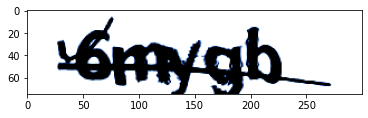

In [12]:
# train_dataset[0]
npimg = train_dataset[200]["images"].numpy()
# npimg
# npimg.shape
# np.transpose(npimg, (1,2,0)).shape
plt.imshow(np.transpose(npimg, (1,2,0)))